# import the dependencies

In [1]:
import sys
from collections import Counter

import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from transformers import RobertaTokenizerFast


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Prepare data

In [3]:
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

# print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count testing samples: 739


In [4]:
print("Load additional dataset")
all_data = pd.read_csv("../lstm_lo_steps_prediction/data/steps_simple_term_str_v1.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

train_df_0 = pd.DataFrame({"steps_num_lo": y_train_, "simple_terms": x_train})
all_data = pd.concat([all_data, train_df_0])

x_train, y_train_ = all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist()

print(f"Count training samples: {len(y_train_)}")

Load additional dataset
Count all terms: 44568

Count original terms: 44568

max steps count: 30
min steps count: 0
Count training samples: 41224


In [5]:
sequence_len = 512

tokenizer = RobertaTokenizerFast.from_pretrained("./fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

train_df = pd.DataFrame({"term_str": x_train, "steps_lo": y_train_})
test_df = pd.DataFrame({"term_str": x_test, "steps_lo": y_test_})

label_encoder = {key_: [0.0] * 31 for key_ in range(31)}
for key_ in label_encoder.keys():
    label_encoder[key_][key_] = 1.0

def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor([label_encoder[key_] for key_ in example["steps_lo"]])
    return tokenized_texts, labels


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [7]:
batch_size = 3

train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Configure the model

In [8]:
from transformers import BertConfig

config = BertConfig(
    vocab_size=8,
    hidden_size=64,
    num_hidden_layers=2,
    num_attention_heads=1,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=31
)

# vocab_size=30522,
# hidden_size=768,
# num_hidden_layers=12,
# num_attention_heads=12,
# intermediate_size=3072,
# hidden_act="gelu",
# hidden_dropout_prob=0.1,
# attention_probs_dropout_prob=0.1,
# max_position_embeddings=512,
# type_vocab_size=2,
# initializer_range=0.02,
# layer_norm_eps=1e-12,
# pad_token_id=0,
# position_embedding_type="absolute",
# use_cache=True,
# classifier_dropout=None,

In [9]:
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=31, activation="softmax")(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [10]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  88128       ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

# Train a language model

In [11]:
epochs = 15
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/15
13742/13742 [==============================] - 330s 24ms/step - loss: 2.7434 - accuracy: 0.1402 - val_loss: 2.5796 - val_accuracy: 0.1583
Epoch 2/15
13742/13742 [==============================] - 296s 22ms/step - loss: 2.6510 - accuracy: 0.1532 - val_loss: 2.5658 - val_accuracy: 0.1651
Epoch 3/15
13742/13742 [==============================] - 285s 21ms/step - loss: 2.6303 - accuracy: 0.1568 - val_loss: 2.5266 - val_accuracy: 0.1894
Epoch 4/15
13742/13742 [==============================] - 285s 21ms/step - loss: 2.5989 - accuracy: 0.1585 - val_loss: 2.4835 - val_accuracy: 0.1827
Epoch 5/15
13742/13742 [==============================] - 286s 21ms/step - loss: 2.5768 - accuracy: 0.1658 - val_loss: 2.4702 - val_accuracy: 0.1894
Epoch 6/15
13742/13742 [==============================] - 286s 21ms/step - loss: 2.5692 - accuracy: 0.1664 - val_loss: 2.4723 - val_accuracy: 0.2111
Epoch 7/15
13742/13742 [==============================] - 286s 21ms/step - loss: 2.5520 - accuracy: 0.1734

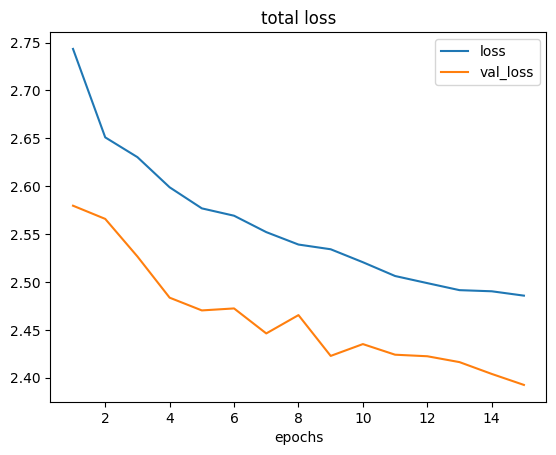

In [12]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

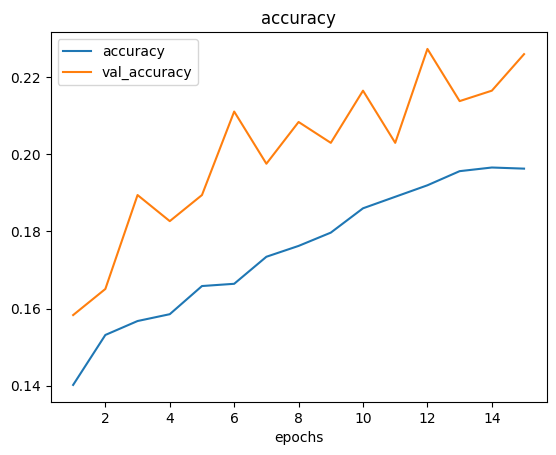

In [13]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [14]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

247/247 [==============================] - 3s 12ms/step


In [15]:
train_preds_nums = [np.argmax(x_) for x_ in train_preds]
test_preds_nums = [np.argmax(x_) for x_ in test_preds]
train_true_nums = y_train_
test_true_nums = y_test_

In [16]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

Train accuracy: 0.21050844168445565


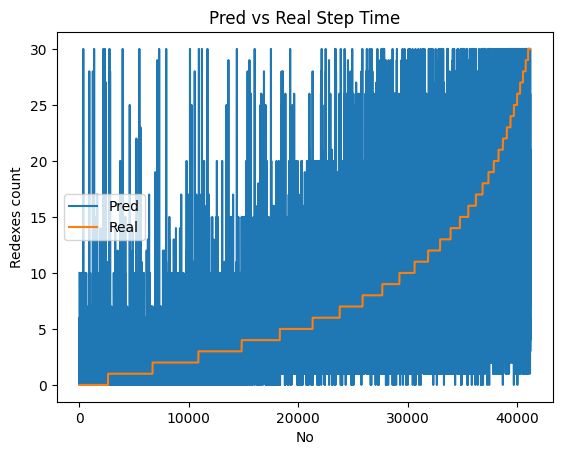

In [17]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)

Test accuracy: 0.2259810554803789


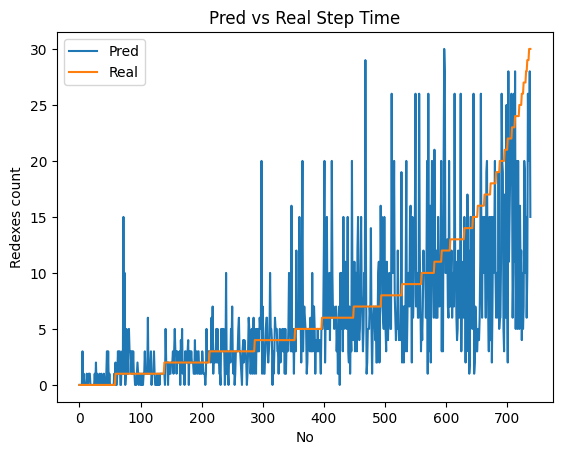

In [18]:
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

In [19]:
def draw_pred_scatter(y_pred, y_real):
    plt.scatter(y_real, y_pred, s=3)
    plt.plot([0, 30], [0, 30], color='gray', linestyle='--')

    plt.xlabel("Real reduction time")
    plt.ylabel("Predicted time")
    plt.title("Pred vs Real Reduction time")
    plt.show()

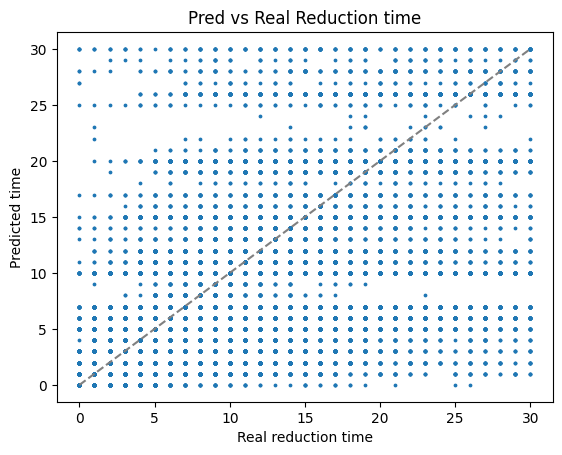

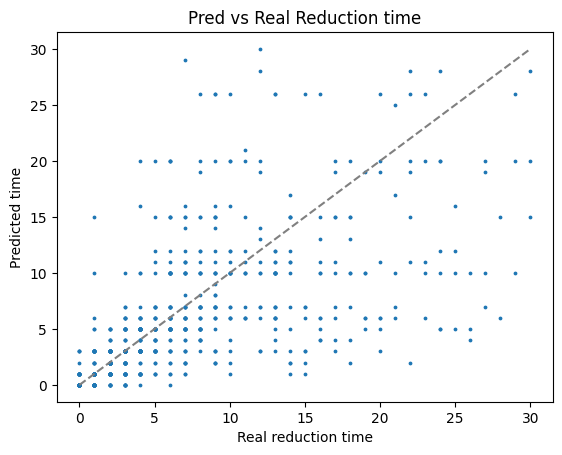

In [20]:
draw_pred_scatter(train_preds_nums, train_true_nums)
draw_pred_scatter(test_preds_nums, test_true_nums)

In [21]:
epochs = 15
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/15
13742/13742 [==============================] - 307s 22ms/step - loss: 2.4761 - accuracy: 0.2002 - val_loss: 2.3713 - val_accuracy: 0.2260
Epoch 2/15
13742/13742 [==============================] - 306s 22ms/step - loss: 2.4664 - accuracy: 0.2047 - val_loss: 2.3717 - val_accuracy: 0.2341
Epoch 3/15
13742/13742 [==============================] - 305s 22ms/step - loss: 2.4635 - accuracy: 0.2049 - val_loss: 2.3720 - val_accuracy: 0.2246
Epoch 4/15
13742/13742 [==============================] - 305s 22ms/step - loss: 2.4623 - accuracy: 0.2048 - val_loss: 2.3759 - val_accuracy: 0.2233
Epoch 5/15
13742/13742 [==============================] - 307s 22ms/step - loss: 2.4678 - accuracy: 0.2031 - val_loss: 2.3646 - val_accuracy: 0.2233
Epoch 6/15
13742/13742 [==============================] - 307s 22ms/step - loss: 2.4566 - accuracy: 0.2069 - val_loss: 2.3850 - val_accuracy: 0.2341
Epoch 7/15
13742/13742 [==============================] - 306s 22ms/step - loss: 2.4522 - accuracy: 0.2094

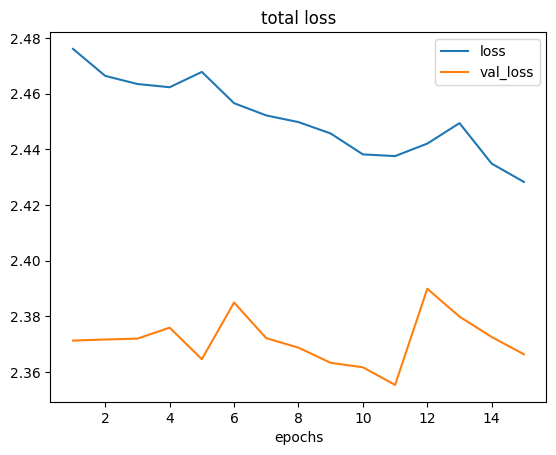

In [22]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

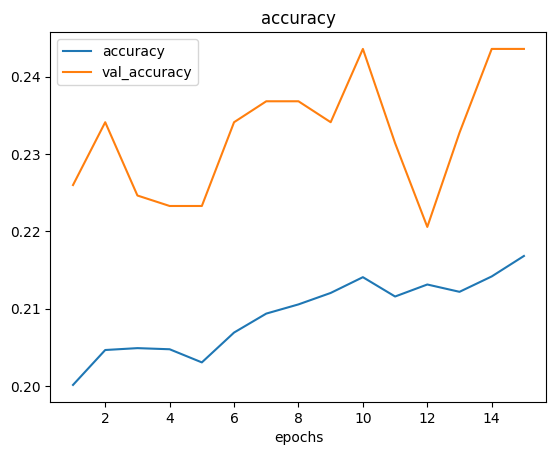

In [23]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [24]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)
train_preds_nums = [np.argmax(x_) for x_ in train_preds]
test_preds_nums = [np.argmax(x_) for x_ in test_preds]
train_true_nums = y_train_
test_true_nums = y_test_

247/247 [==============================] - 3s 11ms/step


Train accuracy: 0.22705220260042694


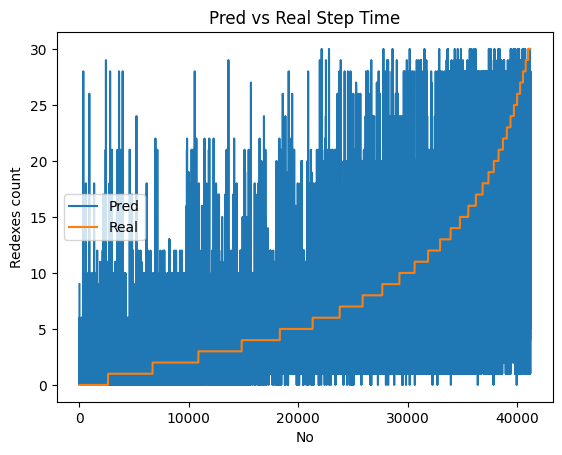

Test accuracy: 0.2435723951285521


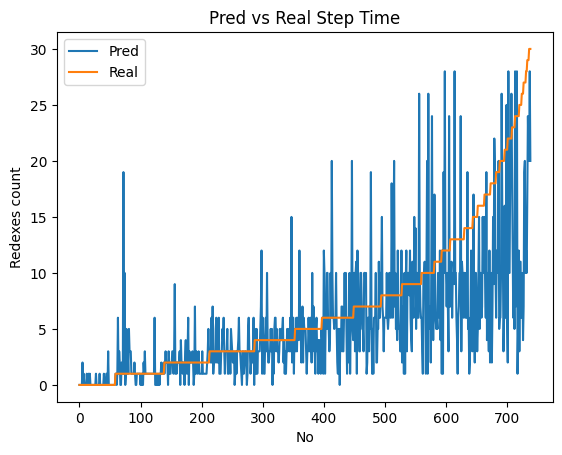

In [25]:
print("Train accuracy:", calculate_accuracy(train_true_nums, train_preds_nums))
draw_pred_lines(train_preds_nums, train_true_nums)
print("Test accuracy:", calculate_accuracy(test_true_nums, test_preds_nums))
draw_pred_lines(test_preds_nums, test_true_nums)

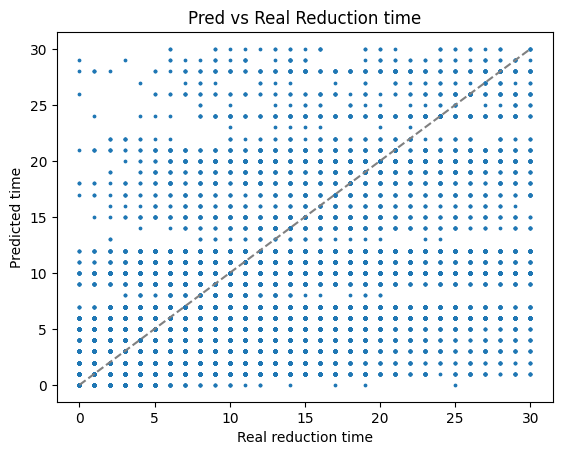

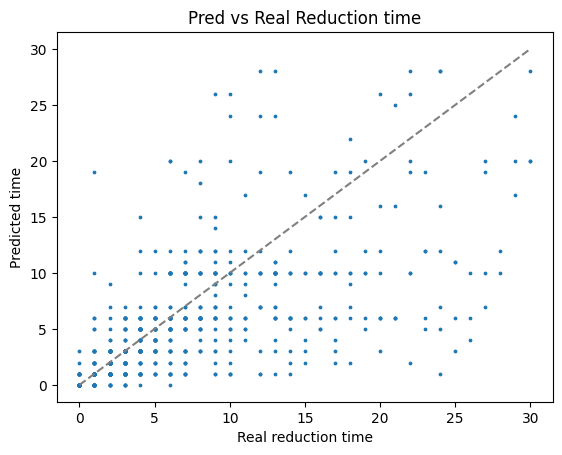

In [26]:
draw_pred_scatter(train_preds_nums, train_true_nums)
draw_pred_scatter(test_preds_nums, test_true_nums)